# 1 载入模块，清除空间

In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import os,sys
import numpy as np
import pandas as pd
from fitter import Fitter
import scipy.stats as st
import matplotlib.pyplot as plt

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体  
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

from sklearn.linear_model import LinearRegression
import time
from IPython.display import clear_output as clear
import pickle

# 2 试一下所有程序一并运行

## 2.1 swc_5day_average 函数

In [3]:
def SWC_5DAY_AVERAGE():
    
    # 0-40cm深度
    SWC["0-40cm"] = SWC["0-10cm"] * ([0.25] * len(SWC)) + SWC["10-40cm"] * ([0.75] * len(SWC))
    
    # 提取3-11月份连续数据
    swc = SWC.loc[:,["Year","Month","Day","0-40cm"]][(SWC["Month"] != 1) & (SWC["Month"] != 2) & (SWC["Month"] != 12)& (SWC["Year"] >= 1961)]
    
    # 5日滑动平均
    a = []
    for i in range(len(swc)):
        if i <= (len(swc)-5):
            a.append(np.mean(swc["0-40cm"][i : (i + 5)]))
        else:
            a.append(0)
    swc["0-40cm_5day_average"] = a.copy() 

    # 只提取5日时间点
    swc_5day_average = swc[::5]
    swc_5day_average.index = np.arange(len(swc_5day_average))    
    
    return(swc_5day_average) 

## 2.2 swc_5day_average_T 函数

In [4]:
def SWC_5DAT_AVERAGE_T():
    
    #列名
    colnames = ["年份"]
    for i in range(1,56):
        colnames.append(str(swc_5day_average.Month[i-1]) + "月" + str(swc_5day_average.Day[i-1]) + "日")
        
    #创建只有年份的数据框
    swc_5day_average_T = pd.DataFrame(data = list(set(swc_5day_average.Year)),columns=["Year"])
    
    #将数据框改为逐日的多年变化
    for month in range(3,12):
        for day in range(min(swc_5day_average.Day[(swc_5day_average.Month == month )& (swc_5day_average.Year == 2000)]),
                         max(swc_5day_average.Day[(swc_5day_average.Month == month )& (swc_5day_average.Year == 2000)]) + 1,
                         5):
            #某一天
            tem = swc_5day_average["0-40cm_5day_average"][(swc_5day_average.Month==month)&(swc_5day_average.Day==day)]
            #更改系列索引
            tem.index = np.arange(len(tem))
            #将系列合并至数据框
            swc_5day_average_T = pd.concat([swc_5day_average_T,tem],axis=1)
        
    # 重新赋值列名
    swc_5day_average_T.columns = colnames
    
    return(swc_5day_average_T)  

## 2.3 cdf_select_function 函数

In [5]:
def cdf_select_function(x):
    distribution=["alpha","anglit","arcsine","argus",
                  "beta","betaprime","bradford","burr","burr12","cauchy","chi","chi2","cosine","crystalball",
                  "dgamma","dweibull",
                  "expon","exponnorm","exponpow","exponweib","exponpow",
                  "f","fatiguelife","fisk","foldcauchy","foldnorm","frechet_r","frechet_l",
                  "genlogistic","gennorm","genextreme","gausshyper","gamma","gengamma","genhalflogistic","genlogistic","genpareto","gompertz","gilbrat","gumbel_r","gumbel_l",
                  "halfcauchy","halfgennorm","halflogistic","halfnorm","hypsecant",
                  "invgauss","invgamma","invgauss","invweibull",
                  "johnsonsb","johnsonsu",
                  "kappa4","kappa3","ksone",
                  "laplace","logistic","loggamma","loglaplace","lognorm","lomax",
                  "maxwell","mielke","moyal",
                  "nakagami","ncx2","ncf","nct","norm","norminvgauss",
                  "pareto","pearson3","powerlaw","powerlognorm","powernorm",
                  "rayleigh","rice",
                  "semicircular","skewnorm",
                  "t","trapz","triang","truncexpon","truncnorm","tukeylambda",
                  "uniform",
                  "vonmises_line",
                  "wald","weibull_min","weibull_max"]
    f = Fitter(x,distributions = distribution)
    f.fit()
    
    # 保证分布下的分位数没有缺失值
    cdf_nominal = eval("st." +  f.summary().index[0] + ".cdf(x,*(f.fitted_param[f.summary().index[0]]))")
    for i in range(1,5):
        if np.any(pd.DataFrame(cdf_nominal).isnull() == True):
            cdf_nominal = eval("st." +  f.summary().index[i] + ".cdf(x,*(f.fitted_param[f.summary().index[i]]))")
        else:
            cdf = cdf_nominal.copy() 
            break      
    
    return(cdf)

## 2.4 swc_cdf 函数

In [6]:
def SWC_CDF():
    
    # 空数据集
    swc_cdf = swc_5day_average_T.copy()
    swc_cdf.iloc[:,1:] = np.nan
    
    # 逐个填充
    for i in range(1,56):
        print("Filling the " + str(i) + "th column of swc_cdf")
        swc_cdf.iloc[:,i] = cdf_select_function(swc_5day_average_T.iloc[:,i])
        
    return(swc_cdf)

## 2.5 swc_cdfchange_cdf 函数

In [7]:
def SWC_CDFCHANGE_CDF():
    
    #创建CDF_Change数据框
    swc_cdfchange = swc_5day_average_T.copy()
    swc_cdfchange.iloc[:,1] = [0] * len(swc_cdfchange)
    swc_cdfchange.iloc[:,2:] = np.nan
    
    swc_cdfchange.iloc[:,2:] = np.diff(swc_cdf)[:,1:]
    
    #创建Change_CDF数据框
    swc_cdfchange_cdf = swc_5day_average_T.copy()
    swc_cdfchange_cdf.iloc[:,1] = [0] * len(swc_cdfchange_cdf)
    swc_cdfchange_cdf.iloc[:,2:] = np.nan    
    
    #填充Change_CDF数据框
    for i in range(2,56):
        print("Filling the " + str(i) + "th column of swc_cdfchange_cdf")
        swc_cdfchange_cdf.iloc[:,i] = cdf_select_function(swc_cdfchange.iloc[:,i])
        
    return(swc_cdfchange_cdf)

## 2.6 FLASH_DROUGHT_INDENTIFY 函数

In [8]:
def FLASH_DROUGHT_INDENTIFY():
    
    # RDI指数
    RDI = swc_cdfchange_cdf.copy()
    RDI.iloc[:,2:] = np.nan
    
    # 骤旱起始时间点、极值时间点、结束时间点
    start_time = []
    extreme_time = []
    lag_time = [] 

    # 骤结束时rdi
    rdi = []
    
    #填充条件
    for i in range(len(RDI)): #逐行
        for j in range(1,55): #每一行的各个元素
            if swc_cdfchange_cdf.iloc[i,(j+1)] <= 0.4:#条件1：每次变动速率都小于40%
                RDI.iloc[i,(j + 1)] = RDI.iloc[i,j] - np.sqrt(0.4 - swc_cdfchange_cdf.iloc[i,(j+1)])
            elif swc_cdfchange_cdf.iloc[i,(j+1)] > 0.4:
                RDI.iloc[i,(j + 1)] = 0 
                if (RDI.iloc[i,j] < 0)&(swc_cdf.iloc[i,j] < 0.2):# 条件2 骤末尾swc_cdf小于20%
                    k = 0
                    while RDI.iloc[i,(j - k)] < 0 : # 计算骤持续时间段j - k -> j 
                        k = k + 1 
                    m = 0
                    while (swc_cdf.iloc[i,(j + m)] < 0.2):# 计算旱持续时间j + 1 ->j + m-1
                        m = m + 1
                        if (j + m) == 56:
                            break            
                    if ((np.diff(swc_cdf.iloc[i,(j - k):(j + 1)]) < 0).all())&(swc_cdf.iloc[i,(j - k)] > 0.4)&(k >= 3):
                        # 条件3、4、5：骤阶段swc_cdf一直减少、初期swc_cdf超过0.4、骤时间超过20天
                        
                        start_time.append([i,(j - k)])
                        extreme_time.append([i,j])
                        lag_time.append([i,(j + m - 1)])
                        rdi.append(RDI.iloc[i,j])
                                                          
    return(start_time,extreme_time,lag_time,rdi,RDI)

## 2.7 FREQUENCY_OF_OCCURRENCE 函数

In [9]:
def FREQUENCY_OF_OCCURRENCE():
    
    # 转变成只有骤旱发生与否的信号数据框
    month_signal = RDI.copy()
    for i,j in start_time:
        month_signal.iloc[i,j] = 1
    month_signal[month_signal != 1] = 0

    # 各个月份的起始时间点
    month_start_time = np.cumsum([7,6,6,6,6,6,6,6,6]).tolist()
    month_start_time.insert(0,0)

    # 各个月骤旱频次
    month_foc = pd.DataFrame()
    for i in range(9):
        month_foc_tem = month_signal.iloc[:,(month_start_time[i]+1):(month_start_time[i + 1]+1)].sum(axis = 1)
        month_foc = pd.concat([month_foc,month_foc_tem],axis = 1)
    
    month_foc.columns = [str(i) + "月" for i in range(3,12)]
    month_foc.index = list(range(1961,2019))
    
    """========================"""
    
    # 各个季节骤旱频次
    season_foc = pd.concat([month_foc.iloc[:,0:4].sum(axis=1),month_foc.iloc[:,4:7].sum(axis=1),month_foc.iloc[:,7:10].sum(axis=1)],axis = 1)
    season_foc.columns = ["春季","夏季","秋季"] 
    season_foc
    
    """========================"""
    
    # 将rdi分区间等级
    rdi_level = pd.cut(rdi,bins = [-100,-2.5,-2,-1.5,-1,0],labels = [4,3,2,1,0])

    # 填充各等级频次的逐年变化数据框
    level_foc = pd.DataFrame(np.zeros(58 * 5).reshape(58,5),columns = [0,1,2,3,4],index = list(range(1961,2019)))
    for x,y in zip(start_time,rdi_level):
        level_foc.iloc[x[0],y] = level_foc.iloc[x[0],y] + 1
    level_foc.columns = ["level_" + str(i) for i in range(1,6)]
    
    return(month_foc, season_foc, level_foc)

## 2.8 对象文件

In [10]:
#设置工作路径
os.chdir("F:/Data/soil_water_content/site")
os.getcwd()

'F:\\Data\\soil_water_content\\site'

In [15]:
#获取文件名
list_names = os.listdir()[173:210]
list_names 

['site_53968.csv',
 'site_53975.csv',
 'site_53986.csv',
 'site_54012.csv',
 'site_54026.csv',
 'site_54027.csv',
 'site_54041.csv',
 'site_54049.csv',
 'site_54063.csv',
 'site_54064.csv',
 'site_54094.csv',
 'site_54096.csv',
 'site_54102.csv',
 'site_54115.csv',
 'site_54134.csv',
 'site_54135.csv',
 'site_54142.csv',
 'site_54157.csv',
 'site_54161.csv',
 'site_54165.csv',
 'site_54181.csv',
 'site_54186.csv',
 'site_54195.csv',
 'site_54208.csv',
 'site_54213.csv',
 'site_54218.csv',
 'site_54226.csv',
 'site_54236.csv',
 'site_54243.csv',
 'site_54254.csv',
 'site_54259.csv',
 'site_54260.csv',
 'site_54263.csv',
 'site_54266.csv',
 'site_54273.csv',
 'site_54276.csv',
 'site_54284.csv']

## 2.9 返回结果

Creating new site_54266...
Filling the 1th column of swc_cdf
Fitted alpha distribution with error=10476.532933485581)
Fitted anglit distribution with error=21650.286570062362)
Fitted arcsine distribution with error=18943.338882470158)
Fitted argus distribution with error=16830.860952850002)
Fitted beta distribution with error=10677.445852013805)
Fitted betaprime distribution with error=10543.711996127215)
Fitted bradford distribution with error=15430.619155970156)
Fitted burr distribution with error=9807.278602348366)
Fitted burr12 distribution with error=9734.477253075776)
Fitted cauchy distribution with error=8619.742541396668)
Fitted chi distribution with error=20287.13729384975)
Fitted chi2 distribution with error=20747.85250052399)
Fitted cosine distribution with error=21650.286570062362)
Fitted crystalball distribution with error=11105.738463130458)
Fitted dgamma distribution with error=8334.606732817198)
Fitted dweibull distribution with error=8466.682423399916)
Fitted expon dis

Fitted johnsonsb distribution with error=12713.171883635021)
Fitted johnsonsu distribution with error=9740.376744596675)
Fitted kappa4 distribution with error=18649.184317245494)
Fitted kappa3 distribution with error=14255.896936442752)
Fitted ksone distribution with error=20903.049591116134)
Fitted laplace distribution with error=9978.077581995853)
Fitted logistic distribution with error=11186.865024544193)
Fitted loggamma distribution with error=13532.35585041688)
Fitted loglaplace distribution with error=10176.223549176497)
Fitted lognorm distribution with error=12718.342062123831)
Fitted lomax distribution with error=17721.30263370954)
Fitted maxwell distribution with error=12860.022408654213)
Fitted mielke distribution with error=11790.498355857359)
Fitted moyal distribution with error=13355.777981434065)
Fitted nakagami distribution with error=13454.528129704657)
Fitted ncx2 distribution with error=22041.986896147733)


KeyboardInterrupt: 

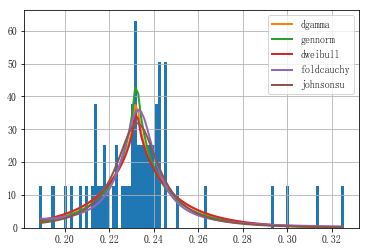

In [16]:
start = time.time()
#逐一转化文件

for site_name in list_names :
    print("Creating new " + site_name[:-4] + "...")
    
    SWC = pd.read_csv(site_name,sep = ",")
    
    swc_5day_average = SWC_5DAY_AVERAGE()
    
    swc_5day_average_T = SWC_5DAT_AVERAGE_T()
    
    swc_cdf = SWC_CDF()
    swc_cdf.to_pickle("F:/Data/flash_drought/SWC_CDF/" + site_name[:-4] + ".pickle")
    
    swc_cdfchange_cdf = SWC_CDFCHANGE_CDF()
    swc_cdfchange_cdf.to_pickle("F:/Data/flash_drought/SWC_CDFCHANGE_CDF/" + site_name[:-4] + ".pickle")
    
    start_time, extreme_time, lag_time, rdi, RDI = FLASH_DROUGHT_INDENTIFY()
    pd.DataFrame(np.array(start_time), columns = [site_name[:-4] + "_Year",site_name[:-4] + "_Season"]).to_pickle("F:/Data/flash_drought/START_TIME/" + site_name[:-4] + ".pickle")
    pd.DataFrame(np.array(extreme_time), columns = [site_name[:-4] + "_Year",site_name[:-4] + "_Season"]).to_pickle("F:/Data/flash_drought/EXTREME_TIME/" + site_name[:-4] + ".pickle")
    pd.DataFrame(np.array(lag_time), columns = [site_name[:-4] + "_Year",site_name[:-4] + "_Season"]).to_pickle("F:/Data/flash_drought/LAG_TIME/" + site_name[:-4] + ".pickle")
    pd.DataFrame(np.array(rdi), columns = [site_name[:-4]]).to_pickle("F:/Data/flash_drought/RDI/" + site_name[:-4] + ".pickle")
    
    month_foc, season_foc, level_foc = FREQUENCY_OF_OCCURRENCE()
    month_foc.to_pickle("F:/Data/flash_drought/MONTH_FOC/" + site_name[:-4] + ".pickle")
    season_foc.to_pickle("F:/Data/flash_drought/SEASON_FOC/" + site_name[:-4] + ".pickle")
    level_foc.to_pickle("F:/Data/flash_drought/LEVEL_FOC/" + site_name[:-4] + ".pickle")
    
    clear()
    
    del SWC, swc_5day_average, swc_5day_average_T, swc_cdf, swc_cdfchange_cdf, start_time, extreme_time, lag_time, rdi, RDI, month_foc, season_foc, level_foc
    
end = time.time()

In [13]:
# 最后清理最快
print(end - start)

#print(START_TIME)
#print(EXTREME_TIME)
#print(foc)

45594.40635728836


# 3 图解骤旱定义

In [301]:
swc_cdf = pd.read_pickle("F:/Data/flash_drought/SWC_CDF/site_50136.pickle")
swc_cdfchange_cdf = pd.read_pickle("F:/Data/flash_drought/SWC_CDFCHANGE_CDF/site_50136.pickle")

start_time = pd.read_pickle("F:/Data/flash_drought/START_TIME/site_50136.pickle")
extreme_time = pd.read_pickle("F:/Data/flash_drought/EXTREME_TIME/site_50136.pickle")
lag_time = pd.read_pickle("F:/Data/flash_drought/LAG_TIME/site_50136.pickle")
rdi = pd.read_pickle("F:/Data/flash_drought/RDI/site_50136.pickle")

## 3.1 change_cdf的计算意义

In [ ]:
# 研究时段
x = swc_cdf.iloc[9, 14:22].index
y = swc_cdf.iloc[9, 14:22]
plt.figure(figsize=(6,4), dpi= 120)
plt.plot(x,y)
plt.locator_params(nbins = 10)

# cdf的变动范围
plt.plot([0, 1,],[0.6940191800554398, 0.6940191800554398-0.3579772061777991,],'k--', linewidth=1)
plt.plot([0, 1,],[0.6940191800554398, 1,],'k--', linewidth=1)
plt.fill_between([0, 1,],[0.6940191800554398, 1,],[0.6940191800554398, 0.6940191800554398-0.3579772061777991,],alpha = 0.3)

# 注释change_cdf
plt.text(0,0.5,"0.017",fontsize = 8)
plt.text(0.3,0.72,"0.84",fontsize = 8)
plt.text(0.1,0.85,"0.99",fontsize = 9)

plt.text(1.4,0.65,"0.07",fontsize = 9)
plt.text(2.3,0.55,"0.34",fontsize = 9)
plt.text(3.3,0.5,"0.25",fontsize = 9)
plt.text(4.3,0.43,"0.23",fontsize = 9)
plt.text(5.3,0.29,"0.07",fontsize = 9)
plt.text(6.3,0.18,"0.49",fontsize = 9)

# 注明非骤过程的线段
plt.plot([0, 1,],[y[0], y[1],],'k', linewidth=2)
plt.plot([6, 7,],[y[6], y[7],],'k', linewidth=2)

# 坐标轴名称
plt.ylabel("soil water content percentile")
plt.xlabel("site 50136 in the year of 1970")
plt.grid()

plt.savefig("F:/Data/flash_drought/why calculate change cdf.png",dpi = 600)

## 3.2 rdi能表征骤的严重程度

In [ ]:
# rdi = -0.997
x = swc_cdf.iloc[36, 34:39].index
y = swc_cdf.iloc[36, 34:39]
plt.figure(figsize=(4,3), dpi= 120)
plt.plot(x,y)
plt.grid()

plt.ylabel("soil water content percentile")
plt.xlabel("rdi = -0.997 at the site 50136 in 1997 ")
plt.savefig("F:/Data/flash_drought/rdi = -0.997.png",dpi = 600)

# rdi = -2.67
x = swc_cdf.iloc[39, 12:19].index
y = swc_cdf.iloc[39, 12:19]
plt.figure(figsize=(4,3), dpi= 120)
plt.plot(x,y)
plt.grid()

plt.ylabel("soil water content percentile")
plt.xlabel("rdi = -2.67 at the site 50136 in 2000 ")
plt.savefig("F:/Data/flash_drought/rdi = -2.67.png",dpi = 600)

## 3.3 rdi与初始土壤湿润程度有关

In [ ]:
# 骤过程土壤含水量百分位数下降值与rdi的关系
swc_cdf_change_volume = []
for x,y in zip(np.array(start_time),np.array(extreme_time)):
    tem = swc_cdf.iloc[x[0],x[1]] - swc_cdf.iloc[y[0],y[1]]
    swc_cdf_change_volume.append(tem)
swc_cdf_change_volume

x = rdi
y = swc_cdf_change_volume
lr = LinearRegression()
lr.fit(x,y)
print(lr.score(x,y))                                        # 决定系数
print(rdi.iloc[:,0].corr(pd.Series(swc_cdf_change_volume))) # 相关系数
y_hat = lr.predict(x)
plt.scatter(x,y)
plt.plot(x, y_hat)
plt.xlabel("rdi")
plt.ylabel("onset-extreme swcp change")
plt.savefig("F:/Data/flash_drought/onset-extreme swcp change.png",dpi = 600)

In [ ]:
# 骤旱起始土壤含水量百分位数与rdi的关系
swc_cdf_start_volume = []
for x in np.array(start_time):
    tem = swc_cdf.iloc[x[0],x[1]]
    swc_cdf_start_volume.append(tem)
swc_cdf_start_volume

x = rdi
y = swc_cdf_start_volume
lr = LinearRegression()
lr.fit(x,y)
print(lr.score(x,y))                                        # 决定系数
print(rdi.iloc[:,0].corr(pd.Series(swc_cdf_start_volume))) # 相关系数
y_hat = lr.predict(x)
plt.scatter(x,y)
plt.plot(x, y_hat)

plt.xlabel("rdi")
plt.ylabel("flash drought onset swcp")
plt.savefig("F:/Data/flash_drought/flash drought onset swcp.png",dpi = 600)

## 3.4 骤旱末期可能会持续一段时间的干旱

In [ ]:
# 输入原始数据
extend_time = (lag_time - extreme_time).iloc[:,1] 
flash_time = (extreme_time - start_time).iloc[:,1] + 1

x = list(range(len(extend_time)))
y1 = flash_time
y2 = extend_time

# 绘制柱状图
plt.figure(figsize=(7,5), dpi= 120)
bar_1 = plt.bar(x,+y1,facecolor = "#9999ff",edgecolor = "white")
bar_2 = plt.bar(x,-y2,facecolor = "#ff9999",edgecolor = "white")

# 为柱加数值
for i,j in zip(x,y1):
    plt.text(i ,j + 0.01,"%d"% j ,ha = "center",va = "bottom",fontsize = 8) # ha为horizontal  alignment 水平对齐

for i,j in zip(x,y2):
    plt.text(i ,-j - 0.01,"%d"% j ,ha = "center",va = "top",fontsize = 8) # va为vertical  alignment 垂直对齐

# 添加图例
plt.legend(handles = [bar_1,bar_2,],labels = ["rapid drought time(pentads)","extend drought time(pentads)"],loc = "best")

# 坐标轴标签与名称
plt.xticks(())
plt.yticks(())

plt.xlabel("每一次骤旱过程")
plt.ylabel("持续时间")

plt.savefig("F:/Data/flash_drought/flash drought total time.png",dpi = 600)